## Load BERT to extract embeddings

In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizerFast, BertModel

In [2]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
em_model = BertModel.from_pretrained('bert-base-uncased')

import torch.nn.functional as F

# Locate the target word in the tokenized sentence
def find_sublist(tokens, sub_tokens):
    n = len(sub_tokens)
    for i in range(len(tokens) - n + 1):
        if [t.lstrip("##") for t in tokens[i:i+n]] == [st.lstrip("##") for st in sub_tokens]:
            return i, i+n
    return None

def extract_target_vector(template, target_word):
    """
    Replace placeholder in template sentence, compute the average vector for the target word.
    """
    filled_sentence = template.replace("[MASK]", target_word)
    inputs = tokenizer(filled_sentence, return_tensors="pt", return_offsets_mapping=True)
    offset_mapping = inputs.pop("offset_mapping")  # Extract offset mapping
    
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())
    target_token_ids = tokenizer(target_word, add_special_tokens=False)["input_ids"]
    target_tokens = tokenizer.convert_ids_to_tokens(target_token_ids)
    
    
    
    match = find_sublist(tokens, target_tokens)
    if not match:
        raise ValueError("Target word tokens not found in the sentence.")
    start_idx, end_idx = match

    # Forward pass to obtain hidden states
    with torch.no_grad():
        outputs = em_model(**inputs)
    last_hidden_state = outputs.last_hidden_state  # (1, sequence_length, hidden_size)

    # Extract and average target token vectors
    target_vectors = last_hidden_state.squeeze()[start_idx:end_idx]
    avg_vector = target_vectors.mean(dim=0)
    return avg_vector

def compute_avg_vector(target_word, templates):
    vectors = [extract_target_vector(template, target_word) for template in templates]
    return torch.stack(vectors, dim=0).mean(dim=0)  # Average across all templates

templates = [
    "This music sounds [MASK].",  
    "The overall tone of this music is [MASK].",   
    "The spectral balance and tonal quality of this music feel [MASK], defining its timbre.",  
]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
mmax = np.ones((40,)) * 4
mmin = np.ones((40,)) * -4

## Load the trained model and listen

In [ ]:
# Using Gammatone to apply filters
!pip install git+https://github.com/detly/gammatone.git

In [4]:
from gammatone import filters 
import soundfile as sf
import IPython.display

In [5]:
# Load and listen to original audio sample

x, fs = sf.read('e_gtr_short.wav')
print(f"Loaded {x.shape[0]} samples at fs={fs}")
IPython.display.Audio(x,rate=fs)

Loaded 458317 samples at fs=44100


In [6]:
# Create filters
c_freqs = filters.centre_freqs(fs, 40, 20)
fcoefs = filters.make_erb_filters(fs, c_freqs, width=1.0)

# Apply filterbank to audio signal and apply a given gain waiting value  to each band.
filterbank_x = filters.erb_filterbank(x, fcoefs)

1/1 [==============================] - 0s 50ms/step


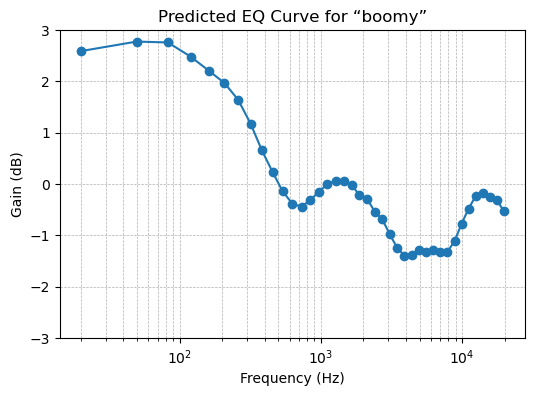

In [7]:
test_words = 'boomy'
test_model = keras.models.load_model('BERT_FourthFold_MAE.keras')
test_vec   = compute_avg_vector(test_words,templates)

test_vec = test_vec.detach().cpu().numpy()   # 转换为 numpy 数组
test_vec = test_vec.reshape(1, -1)            # 确保形状为 (1, 768)
p = test_model.predict(test_vec)

# y_test = (y_test - mmin) / (mmax - mmin)
p = p * (mmax - mmin) + mmin

# 假设 p 已经是反归一化后的预测结果，形状 (1,40)
gains_db = np.flip(1.5*p[0])  

# c_freqs 由你之前计算过
# c_freqs = filters.centre_freqs(fs, 40, 20)

plt.figure(figsize=(6,4))
plt.plot(c_freqs, gains_db, marker='o')      
plt.xscale('log')                             
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.ylim(-3.0, +3.0)
plt.title(f"Predicted EQ Curve for “{test_words}”")
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()

# Apply filterbank to audio signal and apply a given gain waiting value  to each band.
# Select a term (from the list above) and listen.
filterbank_x = filters.erb_filterbank(x, fcoefs)
out = np.sum(filterbank_x.T * np.flip(1.5*p[0, :]),axis=1)
IPython.display.Audio(out,rate=fs)